# Предсказание снижения пользовательской активности. МО

## Описание проекта

Интернет-магазин продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории.

Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Цель**

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Задачи**

1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

### План работы

1. [Загрузка данных](#section_1)
* Импортировать библиотеки, загрузить полученные файлы.
    
    
2. [Предобработка данных](#section_2)
* Проверить наличие пропусков данных, дублирующиеся строки и неявные дубликаты в датафреймах.
* Проверить типы данных датафреймов.
    
    
3. [Исследовательский анализ данных](#section_3)
* Провести статистический анализ количественных данных. Изучить необычные значения.
* Изучить распределение категориальных данных.
    
    
4. [Объединение таблиц](#section_4) 
* Объединить необходимые для обучения модели данные.
    
    
5. [Корреляционных анализ](#section_5)
* Проверить данные на мультиколлинеарность.
    
    
6. [Выбор модели МО](#section_6)
* Подготовить выборки для обучения и тестирования модели МО.
* Подготовить пайплайн для кодирования и скалирования данных.
* Подготовить параметры нескольких моделей МО.
* Поиск лучшей модели МО для предсказания покупательской активности клиентов.
    
    
7. [Анализ важности признаков](#section_7)
    

9. [Сегментация покупателей](#section_8)


10. [Подвести итоги проделанной работы](#section_9)

<a id='section_1'></a>
## Загрузка данных

1. Импортируем необходимые библиотеки.

In [ ]:
!pip install phik shap matplotlib==3.5.3 numpy==1.22 seaborn==0.11.1 -q
!pip install -U scikit-learn -q

In [1]:
import pandas as pd
import numpy as np

# загружаем библиотеки для визуализации 
import matplotlib.pyplot as plt
import seaborn as sns

# загружаем библиотеку для проверки на мультиколлинеарность признаков
import phik

# загружаем класс train_test_split для разделения данных на выборки
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve

# импортируем классы RandomizedSearchCV, GridSearchCV для оптимизации гиперпараметров
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели МО
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 
from sklearn.metrics import confusion_matrix

# загружаем shap для интерпретации
import shap
shap.initjs()

2. Загрузим предоставленные файлы с данными.

In [2]:
# загрузим файлы 
try:
    df_market_file = pd.read_csv('/datasets/market_file.csv', index_col='id')
    df_market_money = pd.read_csv('/datasets/market_money.csv', index_col='id')
    df_market_time = pd.read_csv('/datasets/market_time.csv', index_col='id')
    df_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',', index_col='id')

except:
    df_market_file = pd.read_csv('https://example.ru/market_file.csv', index_col='id')
    df_market_money = pd.read_csv('https://example.ru/market_money.csv', index_col='id')
    df_market_time = pd.read_csv('https://example.ru/market_time.csv', index_col='id')
    df_money = pd.read_csv('https://example.ru/money.csv', sep=';', decimal=',', index_col='id')    

3. Ознакомимся с содержимым всех файлов.

In [3]:
# создадим словарь: ключ – название датафрейма, значение – датафрейм
dict_df = {
    'df_market_file':df_market_file,
    'df_market_money':df_market_money,
    'df_market_time':df_market_time,
    'df_money':df_money
}

In [4]:
# для каждого элемента словаря
for df in dict_df:
#     выводим ключ и размер датафрейма
    print(df, dict_df.get(df).shape)
#     выводим первые строки значения (датафрейма)
    display(dict_df.get(df).head())
    print()

df_market_file (1300, 13)


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



df_market_money (3900, 3)


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



df_market_time (2600, 3)


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



df_money (1300, 2)


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Во всех четырех файлах данные соответсвуют описанию.


---
---
---

<a id='section_2'></a>
## Предобработка данных

### Преобразование названий колонок

Оставим кириллические названия колонок, но приведем названия колонок к нижнему регистру и заменим пробел ` ` на нижнее подчеркивание `_`. 

In [5]:
# для каждого элемента словаря
for df in dict_df:
#     приводим названия колонок к нижнему регистру
    dict_df.get(df).columns = [x.lower() for x in dict_df.get(df).columns]
#     заменяем пробелы в названиях колонок на  '_'
    dict_df.get(df).columns = [x.replace(' ', '_') for x in dict_df.get(df).columns]

# так как все замены производились внутри словаря,
# переобъявим переменные с датафреймами
df_market_file = dict_df.get('df_market_file')
df_market_money = dict_df.get('df_market_money')
df_market_time = dict_df.get('df_market_time')
df_money = dict_df.get('df_money')

# выведем результат
# для каждого элемента словаря
for df in dict_df:
#     выводим ключ и размер
    print(df, dict_df.get(df).columns)
#     выводим первые строки значения (датафрейма)
    display(dict_df.get(df).head())
    print()

df_market_file Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



df_market_money Index(['id', 'период', 'выручка'], dtype='object')


,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



df_market_time Index(['id', 'период', 'минут'], dtype='object')


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



df_money Index(['id', 'прибыль'], dtype='object')


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Обработка строковых значений

In [6]:
# выведем данные колонок со строковыми значениями
categorials = list(df_market_file.select_dtypes(include='object').columns)
df_market_file[categorials].head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,популярная_категория
0,Снизилась,премиум,да,Товары для детей
1,Снизилась,премиум,да,Товары для детей
2,Снизилась,стандартт,нет,Домашний текстиль
3,Снизилась,стандартт,да,Товары для детей
4,Снизилась,стандартт,нет,Товары для детей


In [7]:
# для удобства приведем строковые данные к нижнему регистру
# колонки с типом данных 'object' (чтобы не потерять типы данных остальных колонок) перепишем нижним регистром 
df_market_file[categorials] = \
    df_market_file[categorials].apply(lambda x: x.astype(str).str.lower())

# выведем первые строки таблицы
df_market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5
2,215350,снизилась,стандартт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5
3,215351,снизилась,стандартт,да,3.2,5,896,0.99,товары для детей,5,0,6,4
4,215352,снизилась,стандартт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2


Теперь все названия колонок приведены к единому стилю.

### Работа с пропусками

In [8]:
# функция-счетчик пропусков
def isna_counter(df):
    '''
    Take a pandas.DataFrame df and return the count of columns with np.nan values.
    '''
    count = 0
    for el in df.isna().sum():
        if el != 0:
            count += 1
    if count == 0:
        print('пропуски не обнаружены')
    else:
        print('обнаружены пропуски!')
    return count

In [9]:
# для каждого элемента словаря
for df in dict_df:
#     выводим ключ (название датафрейма)
    print(df)
#     применяем функцию-счетчик пропусков
    isna_counter(dict_df.get(df))
    print()

df_market_file
пропуски не обнаружены

df_market_money
пропуски не обнаружены

df_market_time
пропуски не обнаружены

df_money
пропуски не обнаружены



### Работа с дубликатами

#### Явные дубликаты

In [10]:
# для каждого элемента 
for df in dict_df:
#     выводим название датафрейма
    print(df)
#     выводим кол-во дублирующихся строк
    print(f'Кол-во дублирующихся строк: {dict_df.get(df).duplicated().sum()}')
    print()

df_market_file
Кол-во дублирующихся строк: 0

df_market_money
Кол-во дублирующихся строк: 0

df_market_time
Кол-во дублирующихся строк: 0

df_money
Кол-во дублирующихся строк: 0



Явных дубликатов не обнаружено.

#### Неявные дубликаты

***`df_market_file`***

In [11]:
# проверим размеры датафрейма
print(f'shape {df_market_file.shape}')
print()

# выведем количество уникальных значений колонки и их значения
for col in df_market_file.columns:
    print(col, df_market_file[col].nunique())
    if df_market_file[col].nunique() <= 20:
        print(df_market_file[col].unique())
    print()    

shape (1300, 13)

id 1300

покупательская_активность 2
['снизилась' 'прежний уровень']

тип_сервиса 3
['премиум' 'стандартт' 'стандарт']

разрешить_сообщать 2
['да' 'нет']

маркет_актив_6_мес 41

маркет_актив_тек_мес 3
[5 4 3]

длительность 658

акционные_покупки 42

популярная_категория 6
['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']

средний_просмотр_категорий_за_визит 6
[6 4 5 3 2 1]

неоплаченные_продукты_штук_квартал 11
[ 2  4  0  1  3  5  8  6  9 10  7]

ошибка_сервиса 10
[1 2 6 3 7 9 4 5 8 0]

страниц_за_визит 20
[ 5  4  2  3  7  1  6  8  9 14 11 15 16 10 17 13 12 18 19 20]



In [12]:
# избавимся от неявных дубликатов в котонке 'тип_сервиса'
# pаменим 'стандартт' на 'стандарт'
df_market_file['тип_сервиса'].replace('стандартт', 'стандарт', inplace=True)

Дубликатов по ключевым колонкам, включающим `id`, не может быть, так как все значения `id` уникальны.

***`df_market_money`***

In [13]:
# проверим размеры датафрейма
print(f'shape {df_market_file.shape}')
print()

# выведем количество уникальных значений колонки и их значения
for col in df_market_money.columns:
    print(col, df_market_money[col].nunique())
    if df_market_money[col].nunique() <= 20:
        print(df_market_money[col].unique())
    print()

shape (1300, 13)

id 1300

период 3
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

выручка 2776



Неявных дубликатов нет.

***`df_market_time`***

In [14]:
# проверим размеры датафрейма
print(f'shape {df_market_time.shape}')
print()

# выведем количество уникальных значений колонки и их значения
for col in df_market_time.columns:
    print(col, df_market_time[col].nunique())
    if df_market_time[col].nunique() <= 20:
        print(df_market_time[col].unique())
    print()

shape (2600, 3)

id 1300

период 2
['текущий_месяц' 'предыдцщий_месяц']

минут 20
[14 13 10 12  8 11  6  7  9  5 15  4 16 17 19 18 22 20 21 23]



Неявных дубликатов нет.

In [15]:
# исправим опечатку в значении 'предыдцщий_месяц'
df_market_time.replace('предыдцщий_месяц', 'предыдущий_месяц', inplace=True)

# выведем результат замены
df_market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Проверим наличие дубликатов по ключевым параметрам `id`, `период`.

In [16]:
df_market_time[['id', 'период']].duplicated().sum()

0

Данные не содержат дубликатов, отлично.

***d. `df_money`***

In [17]:
# выведем первые 5 строк датафрейма
df_money.head()

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [18]:
df_money.id.duplicated().sum()

0

В нем всего 2 колонки, явных дубликатов было обнаружено, дубликатов по ключевому параметру тоже нет.

### Типы данных

***`df_market_file`***

In [19]:
df_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

Данные, которые отнесены к `object` перетипизируем в `category`. Количественные данные пока оставим как есть.

In [20]:
categorials = list(df_market_file.select_dtypes(include='object').columns)
df_market_file[categorials] = df_market_file[categorials].astype('category')

***`df_market_money`***

In [21]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [22]:
df_market_money['период'] = df_market_money['период'].astype('category')

***`df_market_time`***

In [23]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [24]:
df_market_time['период'] = df_market_time['период'].astype('category')

***`df_money`***

In [25]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


С типами данных этого датафрейма все в порядке.

<a id='section_3'></a>
## Исследовательский анализ данных

In [26]:
plt.rcParams['figure.figsize']

[6.4, 4.8]

In [27]:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.title_fontsize'] = 14

In [28]:
plt.rcParams['figure.figsize']

[10.0, 5.0]


Изучим распределение данных во всех датафреймах.

### `df_market_file`

#### Количественные данные
Построим гистограммы распределения и ящики с усами количественных данных.

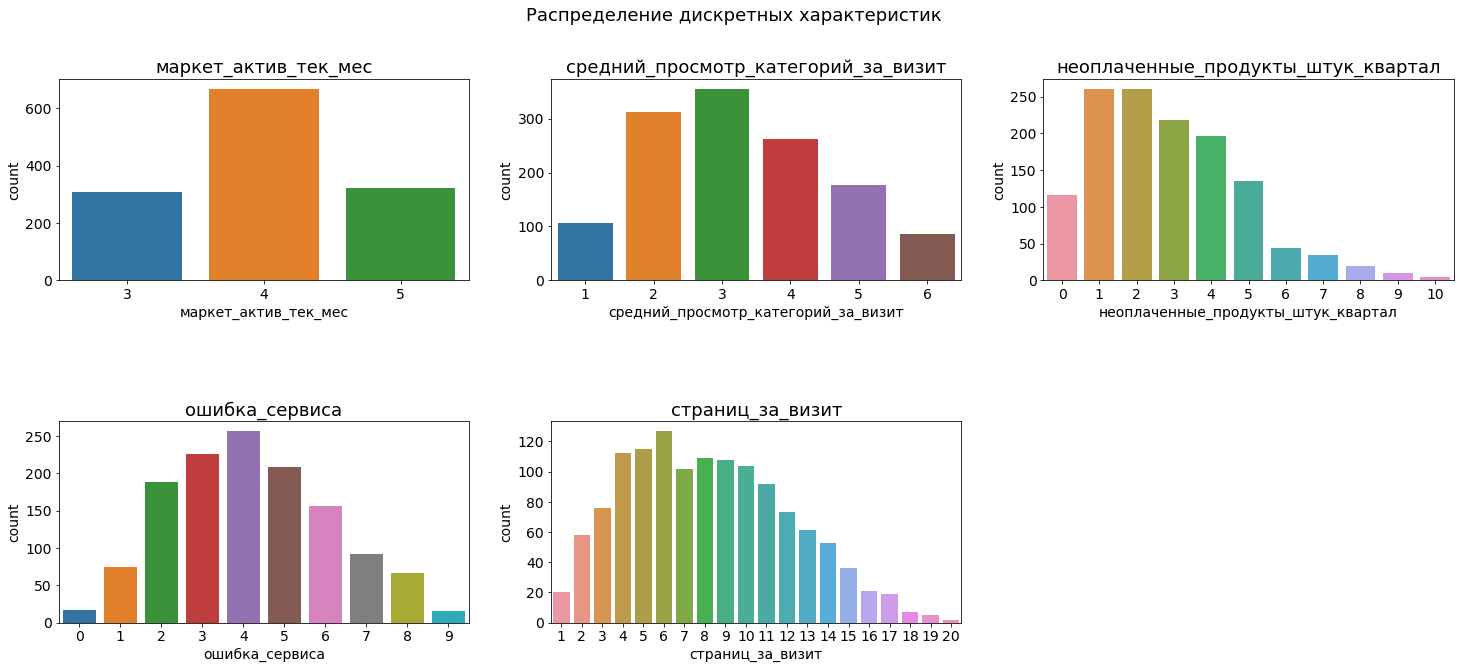

In [29]:
# список названий количественных колонок
discrete_cols = ['маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит',
                  'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(25, 10))
fig.suptitle(f'Распределение дискретных характеристик', fontsize=18)
r = 0
# построим распределение дискретных данных
for i, col in enumerate(discrete_cols):
    c = i % 3
    if i > 2:
        r = 1
    g = sns.countplot(data= df_market_file, x=col, ax=ax[r,c])
    g.set_title(col)
    plt.subplots_adjust(hspace=0.7)
fig.delaxes(ax[1,2])

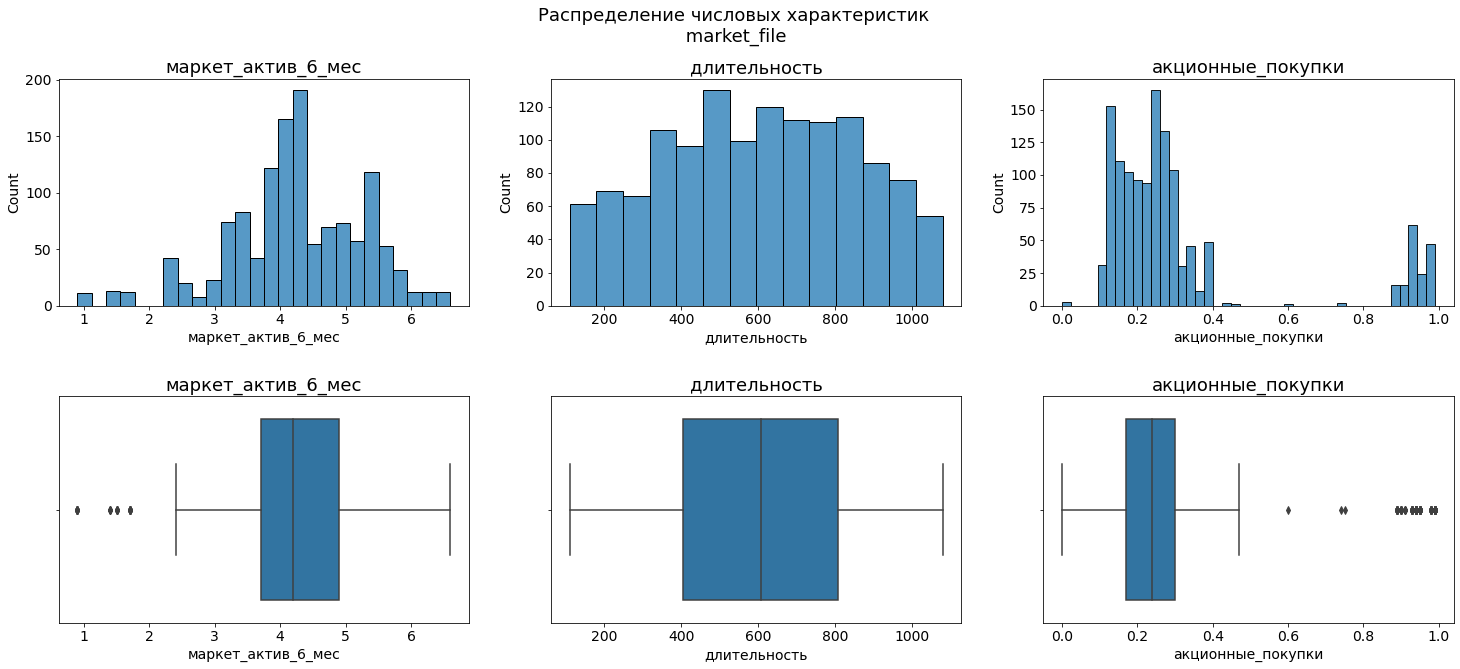

In [30]:
# список названий количественных колонок
numerics_interval = ["маркет_актив_6_мес", "длительность", "акционные_покупки"]

# построим распределение числовых данных
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(25, 10))
fig.suptitle(f'Распределение числовых характеристик\n market_file', fontsize=18)
    
for i, col in enumerate(numerics_interval):
#     гистограмма распределения
    g = sns.histplot(data= df_market_file, x=col, ax=ax[0,i])
    g.set_title(col)
    plt.subplots_adjust(hspace=.4, wspace=.2)  
    g1 = sns.boxplot(data= df_market_file, x=col, ax=ax[1,i])
    g1.set_title(col)
    

In [31]:
df_market_file.query('акционные_покупки > 0.5').shape[0]

168

Почти все количественные данные распределены без выбросов

Исключениями являются: ср. маркетинговая активность за 6 месяцев, кол-во неоплаченных продуктов за квартал.

Среднемесячная доля покупок по акции имеет биномиальное распределение, а в колонке с маркетинговой активностью за текущий месяц только три значния.

#### Категориальные данные
Построим столбики распределения и куски пирога.

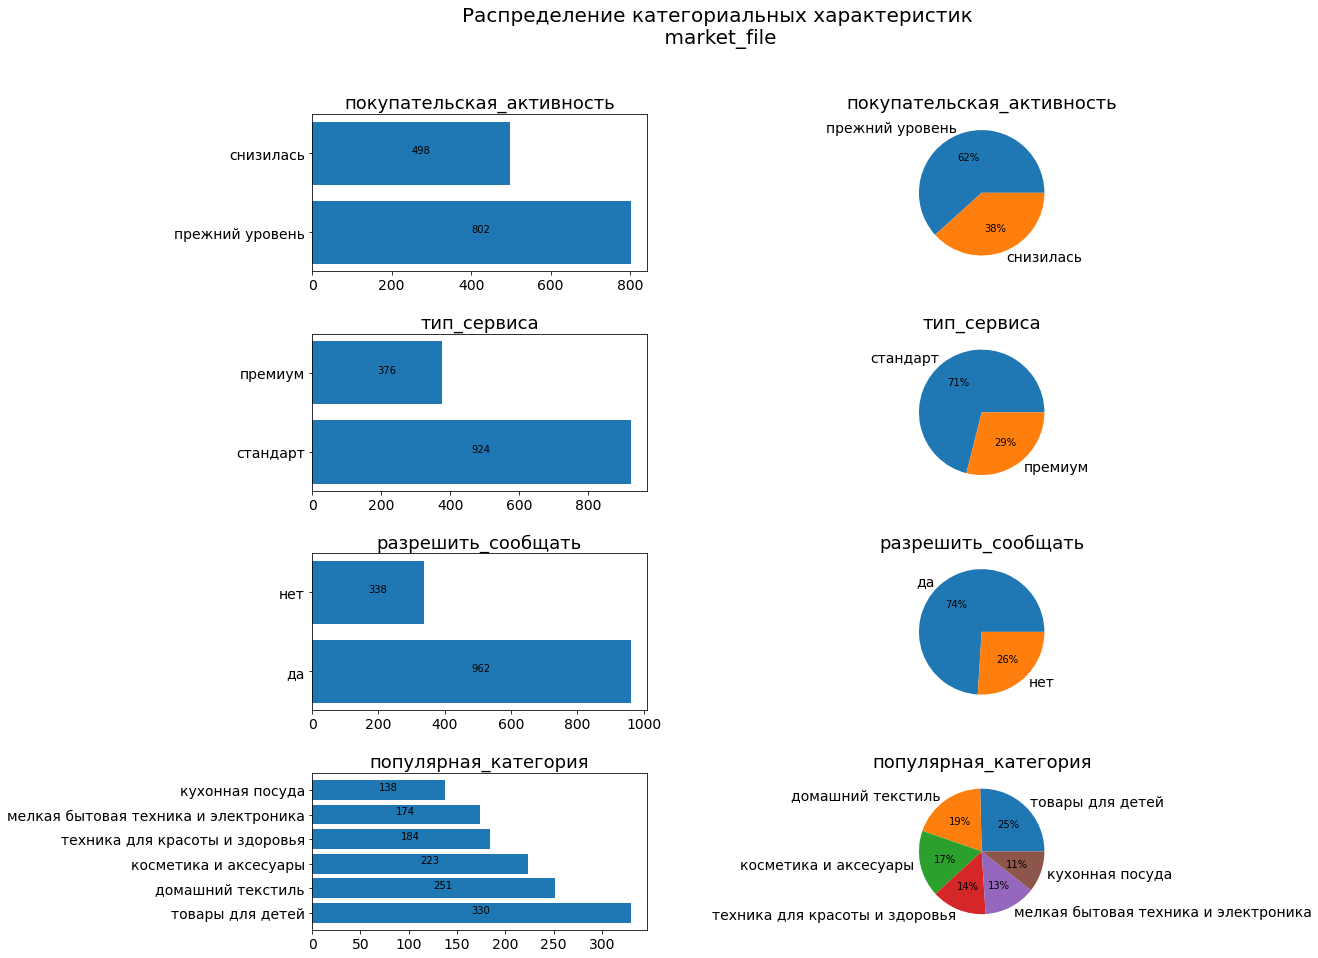

In [32]:
# обновим список категориальных колонок
categorials = list(df_market_file.select_dtypes(include='category').columns)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,15))
fig.suptitle(f'Распределение категориальных характеристик\n market_file', fontsize=20)
for i, col in enumerate(categorials):
    l = df_market_file[col].value_counts().index
    s = df_market_file[col].value_counts()
#     пирог
    ax[i,1].pie(s, labels=l,
                  autopct='%1.0f%%',
#                   textprops={'fontsize': 14},
                  pctdistance=.6, labeldistance=1.1)
    ax[i,1].set_title(col)

#     столбики
    ax[i,0].barh(l,s)
    ax[i,0].set_title(col)
    for k, l in enumerate(s):
        ax[i,0].text(y=k, x=l/2, s=str(l))
    plt.subplots_adjust(wspace=.5, hspace=.4)

Распределение целевого признака (пользовательская активнось), уровня сервиса и согласии на рассылку несбалансированы.

Наиболее популярной категорией покупок являются товары для детей, наименее популярна кухонная посуда.

### `df_market_money`

#### Количественные данные

In [33]:
df_market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

Количественная колонка одна – `Выручка`.

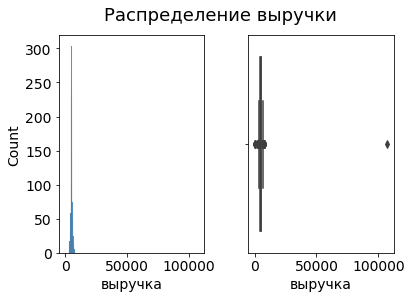

In [34]:
# построим распределение числовых данных
fig, axs = plt.subplots(ncols=2, nrows=1)
fig.suptitle(f'Распределение выручки')
#     гистограмма распределения
sns.histplot(data= df_market_money, x='выручка', ax=axs[0])
#     ящик с усами
sns.boxplot(data= df_market_money, x='выручка', ax=axs[1])

plt.subplots_adjust(wspace=.3)

Видно, что есть выбросы значений.

Выведем количественное описание данных.

In [35]:
df_market_money['выручка'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.0,106862.2


In [36]:
def outlier_remover(data, column, scale=1.5):

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    left_tail = Q1 - scale * IQR
    right_tail = Q3 + scale * IQR

    # Возвращает только те значения, что входят в хвосты.
    return data[(data[column]>= left_tail) & (data[column] <= right_tail)] 

In [37]:
df_market_money = outlier_remover(df_market_money, 'выручка', scale=3)
df_market_money['выручка'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
выручка,3892.0,5006.565519,678.336633,2758.7,4591.95,4959.0,5363.0,7605.3


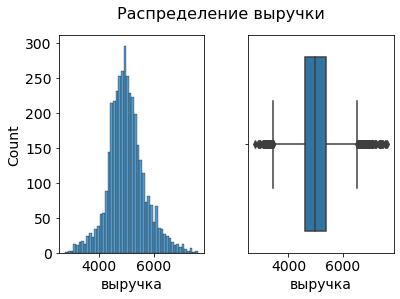

In [38]:
# построим распределение числовых данных
fig, axs = plt.subplots(ncols=2, nrows=1)
fig.suptitle(f'Распределение выручки', fontsize=16)
#     гистограмма распределения
sns.histplot(data= df_market_money, x='выручка', ax=axs[0])
#     ящик с усами
sns.boxplot(data= df_market_money, x='выручка', ax=axs[1])

plt.subplots_adjust(wspace=.3)

#### Категориальные данные

Категориальная колонка – `Период`.

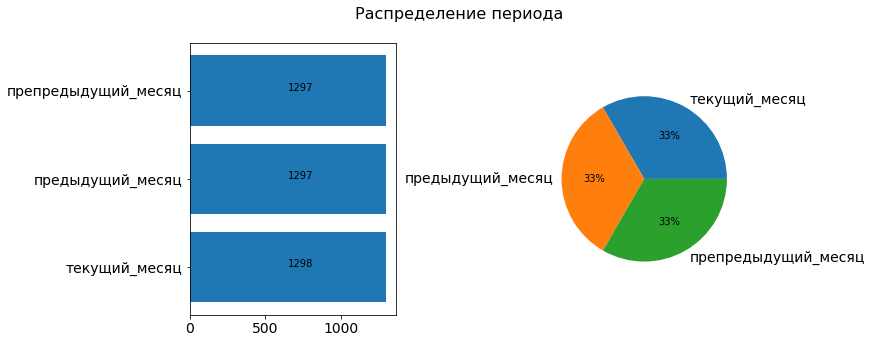

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(f'Распределение периода', fontsize=16)
l = df_market_money['период'].value_counts().index
s = df_market_money['период'].value_counts()
ax[1].pie(s, labels=l,
              autopct='%1.0f%%',
              pctdistance=.6, labeldistance=1.1)

ax[0].barh(l,s)
for k, l in enumerate(s):
    ax[0].text(y=k, x=l/2, s=str(l))
plt.subplots_adjust(wspace=0.7, hspace=.4)

Данные о выручке представлены за три периода: теущий, предыдущий и препредыдвущий месяцы. Распределение выручки по периодам равномерно.

### `df_market_time`

In [40]:
df_market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

#### Количественные данные
Количественная характеристика – `минут`.

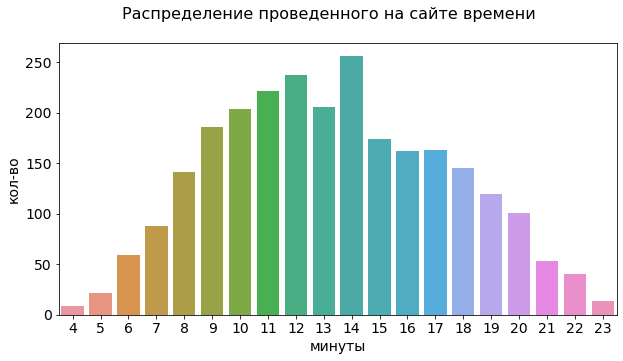

In [41]:
# построим распределение числовых данных
#     гистограмма распределения
fig = plt.figure(figsize=(10, 5))
sns.countplot(data= df_market_time, x='минут')
fig.suptitle(f'Распределение проведенного на сайте времени', fontsize=16)
plt.xlabel("минуты")
plt.ylabel("кол-во")
plt.show()


Распределение времени, проведенного клиентами на сайте, близко к нормальному. Выбросов не наблюдается.

#### Категориальные данные
Категориальная колонка – `Период`.

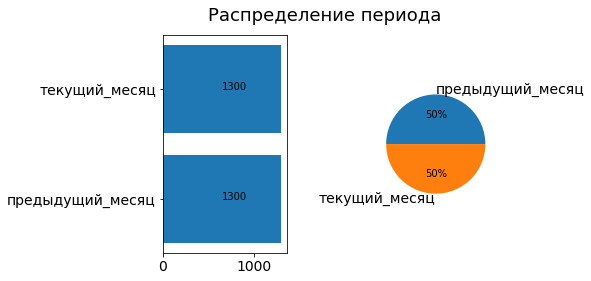

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(f'Распределение периода')
l = df_market_time['период'].value_counts().index
s = df_market_time['период'].value_counts()
ax[1].pie(s, labels=l,
              autopct='%1.0f%%',
#               textprops={'fontsize': 13},
              pctdistance=.6, labeldistance=1.1)

ax[0].barh(l,s)
for k, l in enumerate(s):
    ax[0].text(y=k, x=l/2, s=str(l))
plt.subplots_adjust(wspace=0.7, hspace=.4)

Данные о времени на сайте приведены за только 2 периода: текущий и предыдущий месяц. распределение между ними 50/50.

### `df_money`

В данном датафрейме только одна колонка - количественная.

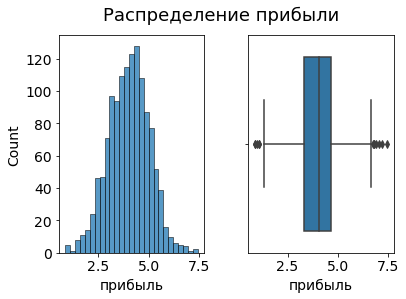

In [43]:
# построим распределение числовых данных
fig, axs = plt.subplots(ncols=2, nrows=1)
fig.suptitle(f'Распределение прибыли')
#     гистограмма распределения
sns.histplot(data= df_money, x='прибыль', ax=axs[0])
#     ящик с усами
sns.boxplot(data= df_money, x='прибыль', ax=axs[1])

plt.subplots_adjust(wspace=.3)

Среди данных о прибыли имеется незначительное количество выбивающихся значений.

---
---

### Выводы

1. В датафрейме `df_market_file` имеются колонки с выбросами: ср. маркетинговая активность за 6 месяцев, кол-во неоплаченных продуктов за квартал. Ср.месячная доля покупок по акции имеет биномиальное распределение. Данные о маркетинговой активности за текущий месяц имеют только три значния.


2. В датафрейме `df_market_file` распределение целевого признака (пользовательская активнось), уровня сервиса и согласии на рассылку несбалансированы. Наиболее популярной категорией покупок являются `товары для детей`, наименее популярна `кухонная посуда`.


3. В датафрейме `df_market_money` имеются данные, которые не вписываются в ±1.5 квантиля (Q1, Q3) от медианы. Данные о выручке представлены за три периода: теущий, предыдущий и препредыдвущий месяцы. Распределение выручки по периодам равномерно.


4. В датафрейме `df_market_time` спределение времени, проведенного клиентами на сайте, близко к нормальному. Данные о времени на сайте приведены за только 2 периода: текущий и предыдущий месяц. распределение между ними 50/50.


5. Среди данных о прибыли имеется незначительное количество выбивающихся значений.

---
---
---

<a id='section_4'></a>
## Объединение таблиц

Необходимо собрать данные из датафреймов `df_market_file`, `df_market_money`, `df_time` в один датафрейм. 

1. Подготовим данные к объединению.

In [44]:
# разделим данные в колонке 'выручка' по значениям колонки 'период'
# переименуем колонки
df_market_money = df_market_money.pivot(index='id', columns='период', values='выручка').rename(
    columns={'препредыдущий_месяц': 'выручка_препредыдущий_месяц',
             'предыдущий_месяц': 'выручка_предыдущий_месяц',
             'текущий_месяц': 'выручка_текущий_месяц'}
)

# выведем размер обновленного датафрейма и первые строки
print(df_market_money.shape)
df_market_money.reset_index().head()

(1300, 3)


период,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215348,NaN,NaN,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5


Повторим для второго датафрейма.

In [45]:
# разделим данные в колонке 'минут' по значениям колонки 'период'
# переименуем колонки
df_market_time = df_market_time.pivot(index='id', columns='период', values='минут').rename(
    columns={'предыдущий_месяц': 'минуты_предыдущий_месяц', 'текущий_месяц': 'минуты_текущий_месяц'})
print(df_market_time.shape)
df_market_time.reset_index().head()

(1300, 2)


период,id,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


2. Объединим датафреймы по колонке `id`.

In [46]:
# создадим новый датафрейм, в котором будут объединены таблицы 'df_market_file', 'df_market_money', 'df_market_time' по 'id'
df_market = df_market_file.merge(df_market_money, on='id').merge(df_market_time, on='id')

# выведем первые строки таблицы
df_market.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


3. Проверим пропуски данных.

In [47]:
# посмотрим количество пропусков в колонках
df_market.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               3
выручка_препредыдущий_месяц            3
выручка_текущий_месяц                  2
минуты_предыдущий_месяц                0
минуты_текущий_месяц                   0
dtype: int64

In [48]:
# 
df_market.drop(df_market[
    df_market['выручка_предыдущий_месяц'].isna() |
    df_market['выручка_текущий_месяц'].isna() |
    df_market['выручка_предыдущий_месяц'].isna()
].index, inplace=True
)

In [49]:
isna_counter(df_market)

пропуски не обнаружены


0

4. Переиндексуем таблицу.

In [50]:
# новыми индексами датафрейма назначим 'id' клиентов
df_market.set_index('id', inplace=True)

# посмотрим сводную информацию по полученной таблице
df_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1295 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   покупательская_активность            1295 non-null   category
 1   тип_сервиса                          1295 non-null   category
 2   разрешить_сообщать                   1295 non-null   category
 3   маркет_актив_6_мес                   1295 non-null   float64 
 4   маркет_актив_тек_мес                 1295 non-null   int64   
 5   длительность                         1295 non-null   int64   
 6   акционные_покупки                    1295 non-null   float64 
 7   популярная_категория                 1295 non-null   category
 8   средний_просмотр_категорий_за_визит  1295 non-null   int64   
 9   неоплаченные_продукты_штук_квартал   1295 non-null   int64   
 10  ошибка_сервиса                       1295 non-null   int64   
 11  страниц_за

---
---
---

<a id='section_5'></a>
## Корреляционный анализ данных

Проверим матрицу корреляции количественных признаков.

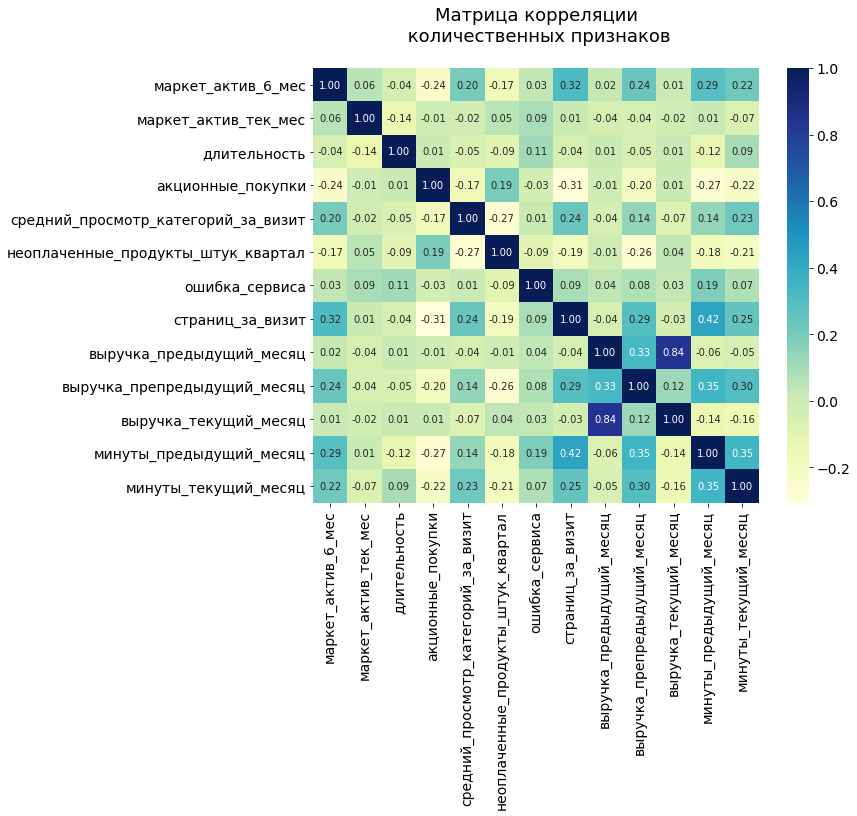

In [51]:
# матрица корреляций
corr_m = df_market.corr()

plt.figure(figsize=(10,8))
# визуализируем ее сиборном
sns.heatmap(corr_m, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Матрица корреляции\n количественных признаков\n')
plt.show()

Мультиколлинеарности между количественными признакми не наблюдается.

In [52]:
numerics_interval

['маркет_актив_6_мес', 'длительность', 'акционные_покупки']

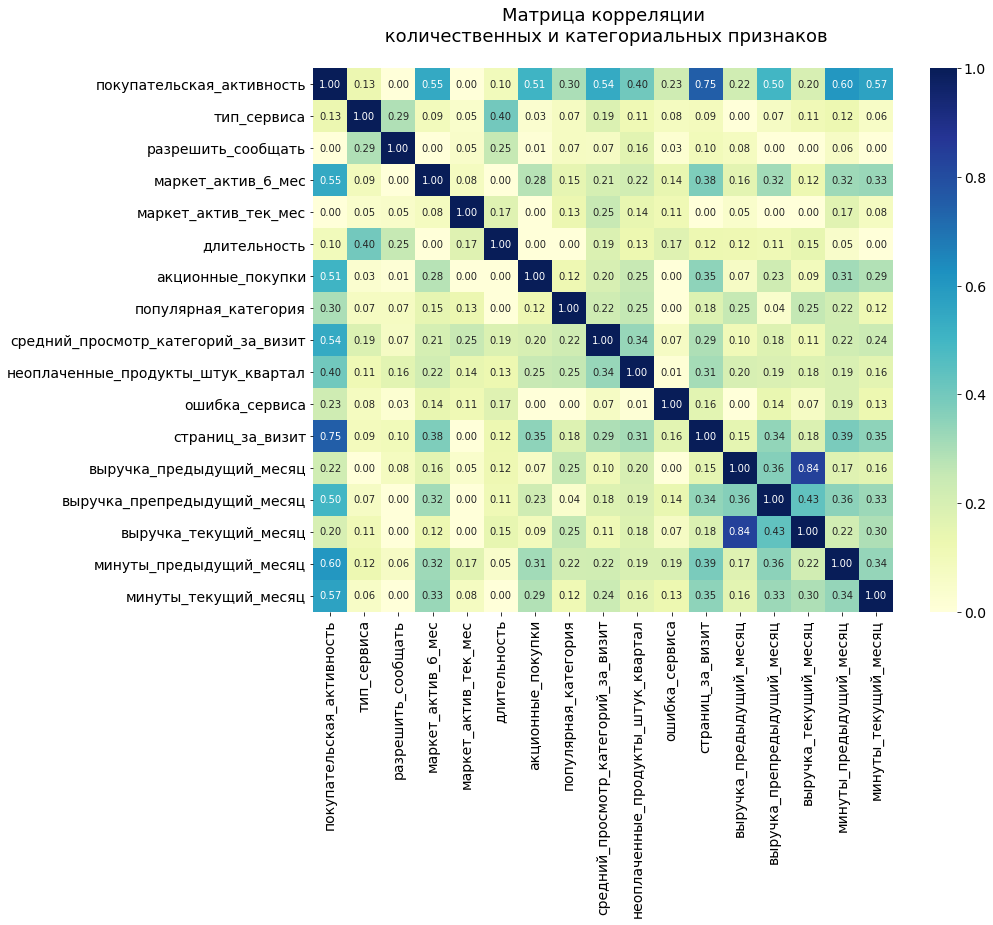

In [53]:
# матрица корреляции всех признаков
numerics_interval.extend(
    ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц'])
phik_m = df_market.phik_matrix(interval_cols=numerics_interval)

plt.figure(figsize=(13,10))
sns.heatmap(phik_m, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Матрица корреляции\n количественных и категориальных признаков\n')
plt.show()

Мультиколлинеарности между входными признаками не наблюдается.

Среди входных признаков имеются такие, что их линейная корреляция с целевым признаком нулевая или очень низкая.

---
---

### Выводы

Мультиколлинеарности между входными признаками не наблюдается.

---
---
---

<a id='section_6'></a>
## Выбор лучшей модели МО

### Разделение данных

In [54]:
# зафиксируем RANDOM_STATE
RANDOM_STATE = 42
# зафиксируем TEST_SIZE
TEST_SIZE = 0.25

In [55]:
# разделим данные на тренировочную и тестовую выборку
# стратифицируем по целевому признаку
X_train, X_test, y_train, y_test = train_test_split(
    df_market.drop('покупательская_активность', axis=1),
    df_market['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_market['покупательская_активность'])
# выведем размерности выборок
X_train.shape, X_test.shape

((971, 16), (324, 16))

### Пайплайны. Подготовка данных.

In [56]:
# объявим LabelEncoder для кодирования целевого признака
le = LabelEncoder()
# обучим на тренировочных данных
le.fit(y_train)
# сохраним кодированные данные для тренировочной и тестовой выборок
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [57]:
# выведем названия количественных и категориальных колонок
print(f'категориальные колонки {list(X_train.select_dtypes(include="category").columns)}')
print()
print(f'количественные колонки {list(X_train.select_dtypes(exclude="category").columns)}')

категориальные колонки ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

количественные колонки ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц']


In [58]:
# список колонок для кодирования OrdinalEncoder и OneHotEncoder
ord_columns = ['тип_сервиса', 'разрешить_сообщать']
ohe_columns = ['популярная_категория']

In [59]:
# список колонок для кодирования OneHotEncoder (для линейных моделей)
ohe_columns_lr = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
# список количественных колонок
num_columns = list(df_market.select_dtypes(exclude='category').columns)

In [60]:
# SimpleImputer + ORD + SimpleImputer
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            categories=[['стандарт', 'премиум'], ["нет", "да"]],
            handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [61]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [62]:
# пайплайн подготовки (кодирование, скэйлинг) признаков 
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('ohe', ohe_pipe, ohe_columns),
        ('num', 'passthrough', num_columns)
    ],
    remainder='passthrough'
)

In [63]:
# пайплайн подготовки (кодирование, скэйлинг) признаков для линейных моделей 
data_preprocessor_lr = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns_lr),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

### Пайплайны. Обучение моделей.

In [64]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('classifier', SVC(random_state=RANDOM_STATE))
    ]
)
pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум'],
                                                                                              ['нет',
                                                                                               'да']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(str...
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'выручка_предыдущий_месяц',
                                                   'выручка_препредыдущий_месяц',
                                                   'выручка_текущий_месяц',
                                                   'минуты_предыдущий_месяц',
                                                   'минуты_текущий_месяц'])])),
                ('classifier', SVC(random_state=42))])

In [65]:
# создадим список словарей для подбора модели МО и ее гиперпараметров
param_grid = [    
#     словарь для модели DecisionTreeClassifier()
    {
        'classifier': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'classifier__max_depth': range(2,16),
        'preprocessor': [data_preprocessor],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },    
    
#     словарь для модели SVC()
    {
        'classifier': [SVC(random_state=RANDOM_STATE, probability=True)],
        'classifier__C': [0.1,0.5,1,5],
        'classifier__gamma': ['scale', 'auto'],
        'preprocessor': [data_preprocessor],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    
#     словарь для модели KNeighborsClassifier() 
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': range(5,11),
        'preprocessor': [data_preprocessor_lr],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    
#     словарь для модели LogisticRegression()
    {
        'classifier': [LogisticRegression(random_state=RANDOM_STATE, penalty='l1', solver='saga', max_iter=200)],
        'classifier__C': [0.1,0.5,1,5],
        'preprocessor': [data_preprocessor_lr],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    
#     словарь для модели SVC(kernel='linear') с линейным ядром
    {
        'classifier': [SVC(random_state=RANDOM_STATE, probability=True, kernel='linear')],
        'classifier__C': [0.1,0.5,1,5],
        'preprocessor': [data_preprocessor_lr],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    }
]

В качестве метрики оценки возьмем ROC AUC score, так как она оценивает способность модели различать классы при разных порогах, и эта метрика подходит для сравнения различных моделей между собой.

In [66]:
# найдем лучшую модель с помощью GridSearchCV()
grid_search = GridSearchCV(
#     передаем итоговый пайплайн, как estimator
    pipe_final, 
#     в качестве параметров - список словарей моделей с гиперпараметрами для подбора
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [67]:
# обучим на тренировочных данных
grid_search.fit(X_train, y_train)

# выведем пайплайн лучшей модели
print('Лучшая модель и её параметры:')
display(grid_search.best_estimator_)

Лучшая модель и её параметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум'],
                                                                                              ['нет',
                                                                                               'да']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(str...
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'выручка_предыдущий_месяц',
                                                   'выручка_препредыдущий_месяц',
                                                   'выручка_текущий_месяц',
                                                   'минуты_предыдущий_месяц',
                                                   'минуты_текущий_месяц'])])),
                ('classifier', SVC(C=0.5, probability=True, random_state=42))])

In [68]:
# выведем значение метрики ROC-AUC при кросс-валидации
print(f'Метрика ROC-AUC лучшей модели на кросс-валидации: {grid_search.best_score_:.3f}')

# посчитаем вероятности принадлежности 1 классу для тестовой выборки
y_test_proba = grid_search.predict_proba(X_test)[:,1]
# выведем метрику ROC-AUC для тестовой выборки
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba):.3f}')

Метрика ROC-AUC лучшей модели на кросс-валидации: 0.919
Метрика ROC-AUC на тестовой выборке: 0.906


Проверим точность модели.

In [69]:
# предскажем значения для тренировочной выборки
y_train_pred = grid_search.predict(X_train)
# проверим точность модели на тренировочной выборке
print(f'Точность модели (accuracy) на тренировочной выборке: {accuracy_score(y_train, y_train_pred):.3f}')

# предскажем значения для тестовой выборки
y_test_pred = grid_search.predict(X_test)

# проверим точность можели на тестовой выборке
print(f'Точность модели (accuracy) на тестовой выборке: {accuracy_score(y_test, y_test_pred):.3f}')

Точность модели (accuracy) на тренировочной выборке: 0.911
Точность модели (accuracy) на тестовой выборке: 0.901


Модель на 1% больше ошибается на тренирововчных данных, чем на тестовых, переобучения не наблюдается.

### Сравнение со случайным решением

In [70]:
# инициализируем модель случайных предсказаний
dummy_cf = DummyClassifier(random_state=RANDOM_STATE, strategy='stratified')
# обучим на тренировочных данных
dummy_cf.fit(X_train, y_train)

# предскажем целевой признак и его вероятность принадлежности 1 классу
y_test_pred_dcf = dummy_cf.predict(X_test)
y_test_proba_dcf = dummy_cf.predict_proba(X_test)[:,1]

# выведем метрики случайных предсказаний
print(f'Метрика ROC-AUC dummyclassifier на тестовой выборке: {roc_auc_score(y_test, y_test_proba_dcf):.3f}')
print(f'Точность dummyclassifier (accuracy) на тестовой выборке: {accuracy_score(y_test, y_test_pred_dcf):.3f}')
print(f'Точность модели (accuracy) на тестовой выборке: {accuracy_score(y_test, y_test_pred):.3f}')

Метрика ROC-AUC dummyclassifier на тестовой выборке: 0.495
Точность dummyclassifier (accuracy) на тестовой выборке: 0.522
Точность модели (accuracy) на тестовой выборке: 0.901


Как можем выдеть, наша модель на ~40% эффективнее случайных предсказаний снижения пользовательской активности.

Проверим матрицу ошибок модели.

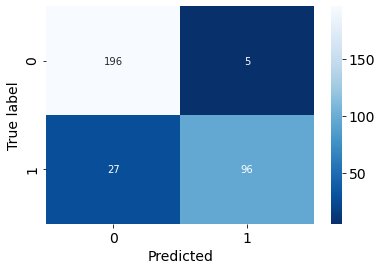

In [71]:
# посчитаем матрицу
cm = confusion_matrix(y_test, y_test_pred)
# выведем результат
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Полученная модель верно предсказала 196 то, что покупательская активность осталась на `прежнем уровене` из 201 (196+5) случая сохранения уровня активности.

Также модель верно предсказала 96 случаев `снижения` покупательской активности из 123 (96+27) случаев снижения пользовательской активности.

Модель ложно предсказала 5 случаев снижения активности из 101 (96+5), при этом она не определила 27 случаев снижения активности из 123 реальных случаев снижения активности.

Таким образом, модель не предсказала ~22% случая снижения пользовательской активности, и только ~5% случаев ложного предсказания снижения пользовательской активности.

### Лучшая модель

In [72]:
# Функция для удаления префиксов
def remove_prefixes(name):
    prefixes_to_remove = ['ohe__', 'num__']
    for prefix in prefixes_to_remove:
        name = name.replace(prefix, '')
    return name

In [73]:
# сохраним лучший пайплайн
best_estimator = grid_search.best_estimator_

# сохраним лучшую модель в переменную
best_model = grid_search.best_estimator_.named_steps['classifier']

# сохраним препроцессор для лучшей модели
best_preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

# получим названия колонок после препроцессинга
features_names = [remove_prefixes(name) for name in best_preprocessor.get_feature_names_out()]

# трансформируем тренировочную и тесстовую выборки
X_train_transformed = best_preprocessor.transform(X_train)
X_test_transformed = best_preprocessor.transform(X_test)

---
---
---

<a id='section_7'></a>
## Анализ важности признаков

In [78]:
# сократим кол-во образцов для объяснения
X_test_shap_samples = shap.sample(X_test_transformed, nsamples=200, random_state=RANDOM_STATE)

# 
explainer = shap.KernelExplainer(best_model.predict_proba, X_test_shap_samples, feature_names=features_names)

shap_values_1 = explainer(X_test_shap_samples)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

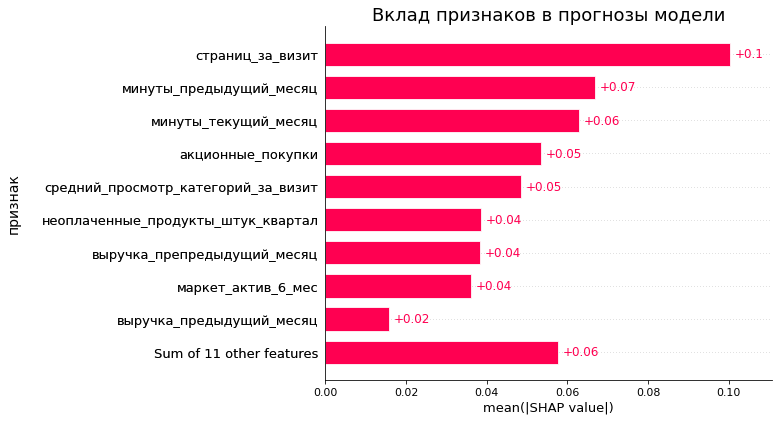

In [79]:
# 
shap.plots.bar(shap_values_1[...,1], show=False)
plt.title('Вклад признаков в прогнозы модели')
plt.ylabel('признак\n', fontsize=14);

Наиболее значимые признаки для модели:
1. кол-во страниц за визит;
2. кол-во минут на сайте в предыдущем месяце;
3. кол-во минут на сайте в текущем месяце;
4. ср.месячная доля покупок по акции;
5. ср. просмотр категорий за визит в течение месяца;
6. кол-во неоплаченных продуктов за квартал;
7. выручка за препредыдущий месяц;
8. ср.месячное значение маркетинговых коммуникаций за полгода; 
9. выручка за предыдущий месяц.


Наименее значимые признаки для модели: все остальные.

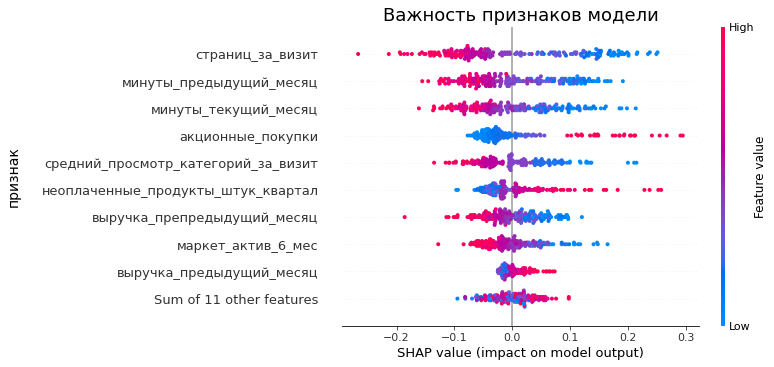

In [80]:
shap.plots.beeswarm(shap_values_1[...,1], show=False)
plt.title('Важность признаков модели')
plt.ylabel('признак\n', fontsize=14);

---
---

<a id='section_7.1'></a>
### Выводы

Вероятность снижения пользовательской активности тем выше, 

1. чем ниже:
    * кол-во просмотренных страниц за визит (1),
    * кол-во минут в предыдущем месяце (2),
    * кол-во минут в текущем месяце (3),
    * ср. кол-во просмотренных категорий за визит (5),
    * ср.месячное кол-во маркетинговых коммуникаций за полгода (7),
    * сумма выручки за предпредыдущий месяц (8);
2. чем выше:
    * ср.месячная доля покупок по акции (4),
    * общее число неоплаченных товаров корзине за последние 3 месяца (6),
    * выручка за предыдущий месяц (9).
    
В скобках указан приоритет важности признака для модели. 

---
---
---

<a id='section_8'></a>
## Сегментация покупателей

Выделим сегмент клиентов на основе данных о прибыльности покупателей и результатам моделирования снижения пользовательской активности клиентов.

In [74]:
# создадим датафрейм с предсказаниями снижения активности пользователей
df_preds = pd.DataFrame(
    best_estimator.predict_proba(df_market.drop('покупательская_активность', axis=1))[:,1],
    columns=['вероятность_снижения_активности'],
    index=df_market.index
)

# соединим его с 'df_market'
df_preds = df_preds.join(df_money.set_index('id'))
# выведем верхние строки 
df_preds.head()

,вероятность_снижения_активности,прибыль
id,,
215349,0.984838,4.16
215350,0.375592,3.13
215351,0.856099,4.87
215352,0.972034,4.21
215353,0.749051,3.95


Тепеперь есть датафрейм, содержащий идентификатор клиента, вероятность снижения активности пользователя и его прибыльность для компании. Посмотрим на распределение этих характеристик и их взаимосвязь.

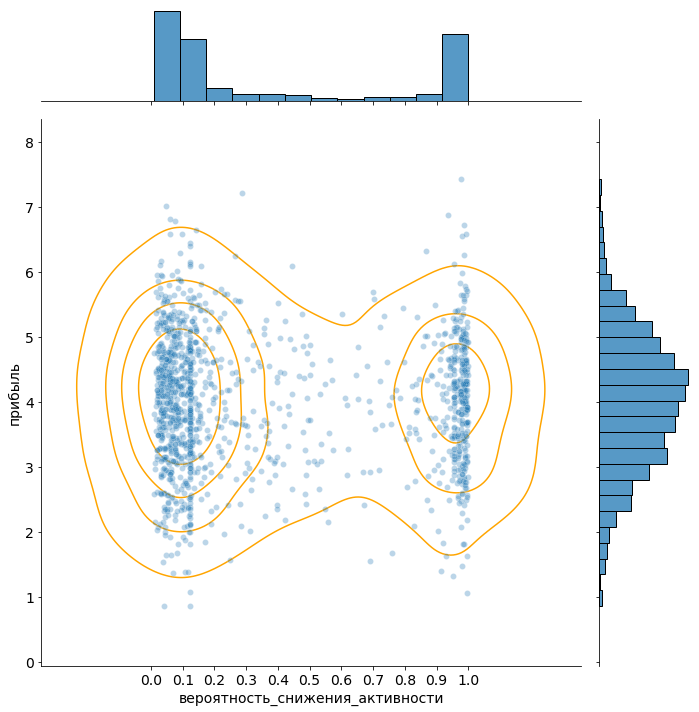

In [75]:
# построим график зависимости прибыльности от вероятности снижения активности
# по осям заложим распределение характеристик
g = sns.jointplot(data=df_preds, x='вероятность_снижения_активности', y='прибыль', alpha=0.3, height=10)
g.plot_joint(sns.kdeplot, color="orange", zorder=0, levels=5)
ax=g.ax_marg_x
ax.set_xticks([i/10 for i in range(11)])
fig.suptitle("Распределение")
plt.show()

Как можем видеть на графике:
    
1. распределение прибыльности клиентов близко к нормальному распределению с серединой в районе 4.
2. распределение вероятности снижения активности имеет 2 пика. Таким образом, существует 2 крайние группы - с высокой и низкой вероятностью снижения активности.

На основе этих 2 фактов изучим сегмент покупателей с высоким риском снижения активности: от 0.9 и более. Сократим сегмент до наиболее прибыльного для компании: от 4 и более.

Так как этот сегмент с высокой вероятностью снижения активности, но он приносит больше прибыли среди таковых, логичнее сохранить пользовательскую активность сегмента.
    
    
    
Для сравнения возьмем остальную выборку клиентов.

In [76]:
# выделим сегмент в датафрейме
# получем айди клиентов сегмента
segment_id = list(df_preds.query('вероятность_снижения_активности >= .9 and 4 <= прибыль').index)
print(f'Кол-во элементов в сегменте {len(segment_id)}')

Кол-во элементов в сегменте 182


In [77]:
df_preds.reset_index(inplace=True)
# добавим столбец с сегментом покупателей
df_preds['сегмент'] = df_preds['id'].apply(lambda x: 'исследумый' if x in segment_id else 'остальные')
df_preds.set_index('id', inplace=True)
# проверим результат
df_preds['сегмент'].value_counts().to_frame()

,сегмент
остальные,1113
исследумый,182


Количество элементов в сегменте совпадает.

Проверим распределение данных.

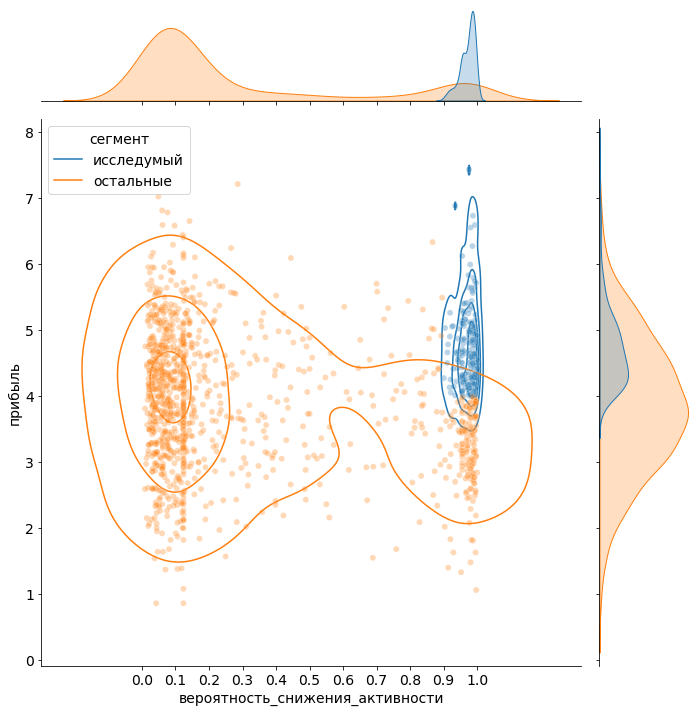

In [78]:
g = sns.jointplot(data=df_preds, x='вероятность_снижения_активности', y='прибыль', hue='сегмент', alpha=0.3, height=10)
g.plot_joint(sns.kdeplot, color="orange", zorder=0, levels=5)
ax=g.ax_marg_x
ax.set_xticks([i/10 for i in range(11)])
fig.suptitle("Распределение")
plt.show()

Графики соответствуют сегментации.

Выделим из датафрейма `df_market` группы клиентов.

In [79]:
# скопируем датафрейм с данными
df_segments = df_market.copy()
# сбросим индексы (id)
df_segments.reset_index(inplace=True)
# добавим столбец с сегментом
df_segments['сегмент'] = df_segments['id'].apply(lambda x: 'исследуемый' if x in segment_id else 'остальные').astype('category')
# вернем индексы (id клиентов)
df_segments.set_index('id', inplace=True)
# удалим столбец с активностью
df_segments.drop('покупательская_активность', axis=1, inplace=True)
# выведем верхние строки
df_segments.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц,сегмент
id,,,,,,,,,,,,,,,,,
215349,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,исследуемый
215350,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,остальные
215351,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,остальные
215352,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,исследуемый
215353,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,остальные


In [80]:
# проверим информацию о получившемся датафрейме
df_segments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1295 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   тип_сервиса                          1295 non-null   category
 1   разрешить_сообщать                   1295 non-null   category
 2   маркет_актив_6_мес                   1295 non-null   float64 
 3   маркет_актив_тек_мес                 1295 non-null   int64   
 4   длительность                         1295 non-null   int64   
 5   акционные_покупки                    1295 non-null   float64 
 6   популярная_категория                 1295 non-null   category
 7   средний_просмотр_категорий_за_визит  1295 non-null   int64   
 8   неоплаченные_продукты_штук_квартал   1295 non-null   int64   
 9   ошибка_сервиса                       1295 non-null   int64   
 10  страниц_за_визит                     1295 non-null   int64   
 11  выручка_пр

Пропусков нет. Типы данных соответствуют.

Изучим распределение характеристик по сегментам. Рассмотрим отдельные графики для дискретных, непрерывных и категориальных переменных.

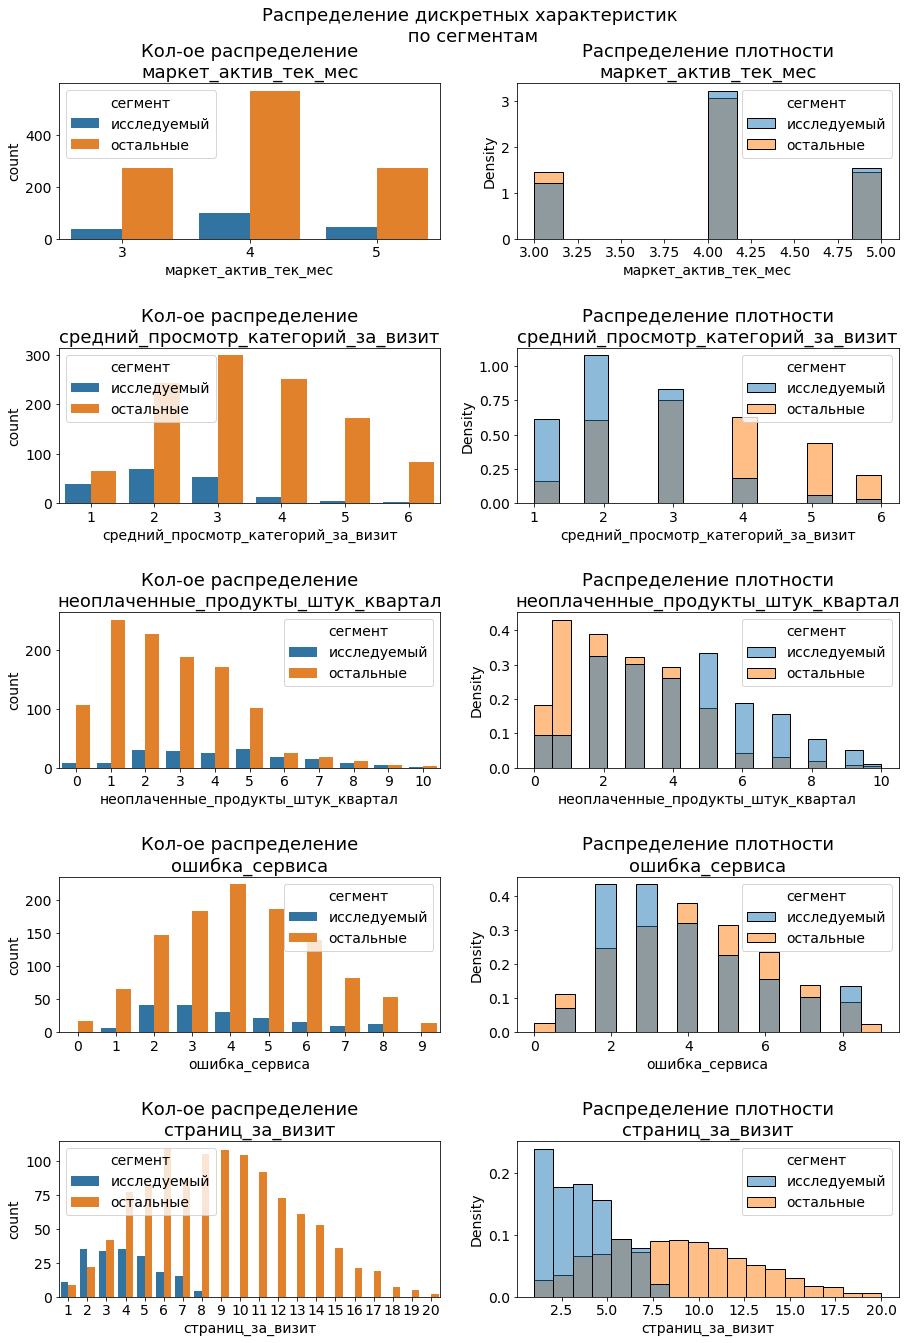

In [103]:
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(15, 20))
fig.tight_layout(pad=10)
fig.suptitle(f'Распределение дискретных характеристик\n по сегментам\n')
plt.subplots_adjust(hspace=0.7, wspace=0.2)
# построим распределение дискретных данных
for i, col in enumerate(discrete_cols):
    axs = sns.countplot(data=df_segments, x=col, ax=ax[i,0], hue='сегмент')
    axs.set_title(f'Кол-ое распределение\n{col}')
    axs_1 = sns.histplot(data=df_segments, x=col, ax=ax[i,1], hue='сегмент', stat='density', common_norm=False)
    axs_1.set_title(f'Распределение плотности\n{col}')
    

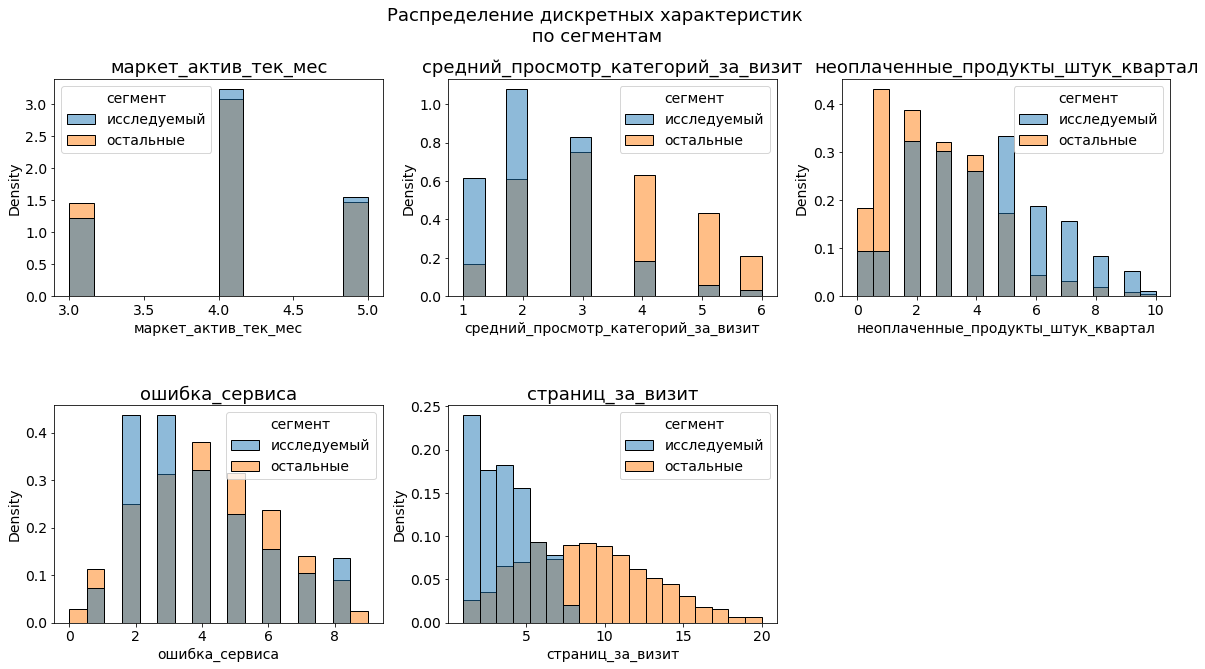

In [87]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
fig.suptitle(f'Распределение дискретных характеристик\n по сегментам')
r = 0
# построим распределение дискретных данных
for i, col in enumerate(discrete_cols):
    c = i % 3
    if i > 2:
        r = 1
    axs = sns.histplot(data=df_segments, x=col, ax=ax[r,c], hue='сегмент', stat='density', common_norm=False)
    axs.set_title(col)
    plt.subplots_adjust(hspace=0.5)
    
fig.delaxes(ax[1,2])

Из графиков распределения плотности можно сделать следующие выводы.
1. Плотность распределения меркетинговой активности за текущий месяц у обеих групп совпадает.
2. Клиенты исследуемого сегмента просматривают меньше категорий за визит, чем группа сравнения.
3. У клиентов сегмента больше неоплаченных продуктов в корзине за квартал, чем у группы сравнения.
4. Клиенты исследуемого сегмента реже сталкиваются со сбоями, что не удивительно, ведь они посещают меньше страниц за визит.

Как было [выявлено ранее](#section_7.1) наиболее значимым параметром для модели является кол-во просмотренных страниц за визит. 

В исследуемом сегменте пик распределения просмотренных страниц приходится на 4-5 страниц, тогда как для группы сравнения он находится на 9 страницах.

Рассмотрим непрерывные характеристики.

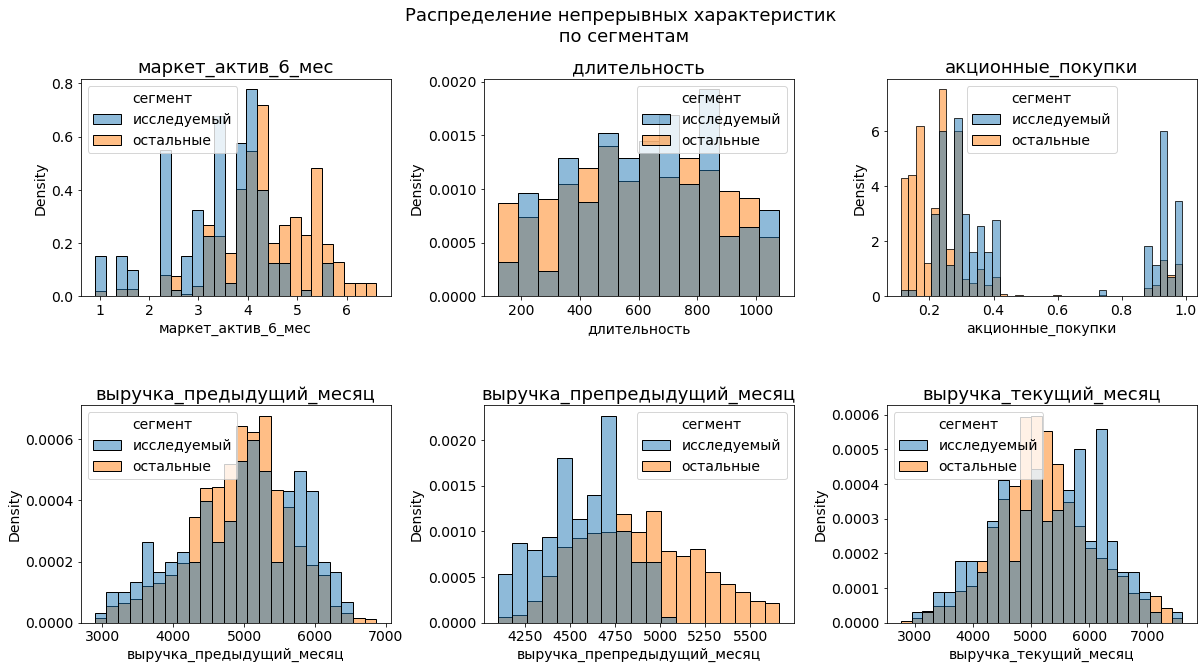

In [85]:
# построим распределение непрерывных данных
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
fig.suptitle(f'Распределение непрерывных характеристик\n по сегментам')
r = 0
for i, col in enumerate(numerics_interval):
    c = i % 3
    if c == 0 and i != 0:
        r += 1
#     гистограмма распределения
    g = sns.histplot(data=df_segments, x=col, hue='сегмент', stat='density', common_norm=False, ax=ax[r,c])
    g.set_title(col)
    plt.subplots_adjust(hspace=.5, wspace=.3)    

На основе графиком можно выдвинуть следующее:
1. За последние полгода исслудуемы сегмент получал мало маркетинговых коммуникаций.
2. Длительность истории с клиентами в основном ~350-850 дней (или ~11,5-28,3 месяца).
3. Доля акционных покупок у клиентов исследуемого сегмента выше, чем у остальной группы.
4. За последние 3 месяца клиенты сегмента начали приносить больше прибыли за месяц.

На основе анализа количественных данных можно сказать, что за текущий месяц сегментские клиенты получали столько же маркетинговых предложений, что и остальная группа, но при этом за полгода на клиентов сегмента в среднем приходится меньше маркетинговых коммуникаций.

Учитывая то, что клиенты сегмента в сравнении с остальными клиентами:
    
* просматривают меньше страниц за визит,
* неоплаченных товаров в корзине за три месяца больше,
* чаще покупают товары по акции.
    
Логично предположить, что клиенты быстро выбирают нужные товары и ждут удобных акций для приобретения товаров.

Рассмотрим категориальные характеристики по сегментам.

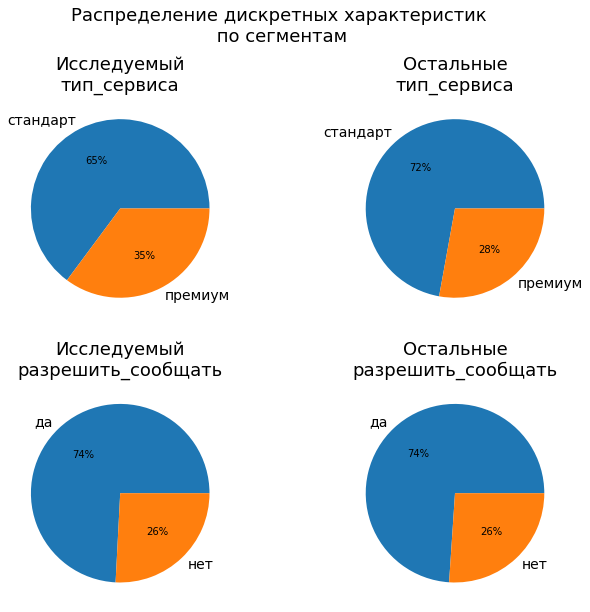

In [90]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
fig.suptitle(f'Распределение дискретных характеристик\n по сегментам\n')
for i, col in enumerate(ohe_columns_lr):
    if col != 'популярная_категория':
#         для целевого сегмента
        l = df_segments.loc[df_segments['сегмент'] == 'исследуемый', col].value_counts().index
        s = df_segments.loc[df_segments['сегмент'] == 'исследуемый', col].value_counts()
        ax[i,0].pie(s, labels=l,
                      autopct='%1.0f%%',
                      pctdistance=.6, labeldistance=1.1)
        ax[i,0].set_title(f'Исследуемый\n{col}')
# для нецелевого
        l1 = df_segments.loc[df_segments['сегмент'] == 'остальные', col].value_counts().index
        s1 = df_segments.loc[df_segments['сегмент'] == 'остальные', col].value_counts()
        ax[i,1].pie(s1, labels=l1,
                      autopct='%1.0f%%',
                      pctdistance=.6, labeldistance=1.1)
        ax[i,1].set_title(f'Остальные\n{col}')
    
    plt.subplots_adjust(hspace=.1, wspace=.5)        
    

Исходя из графиков можно можно сделать следующие выводы:

1. Среди клиентов сегмента больше клиентов с `премиум` сервисом, чем у остальной группы клиентов.


2. Распределение о согласии на рассылку о товарах идентично с остальной группой.


Рассмотрим популярность категорий.

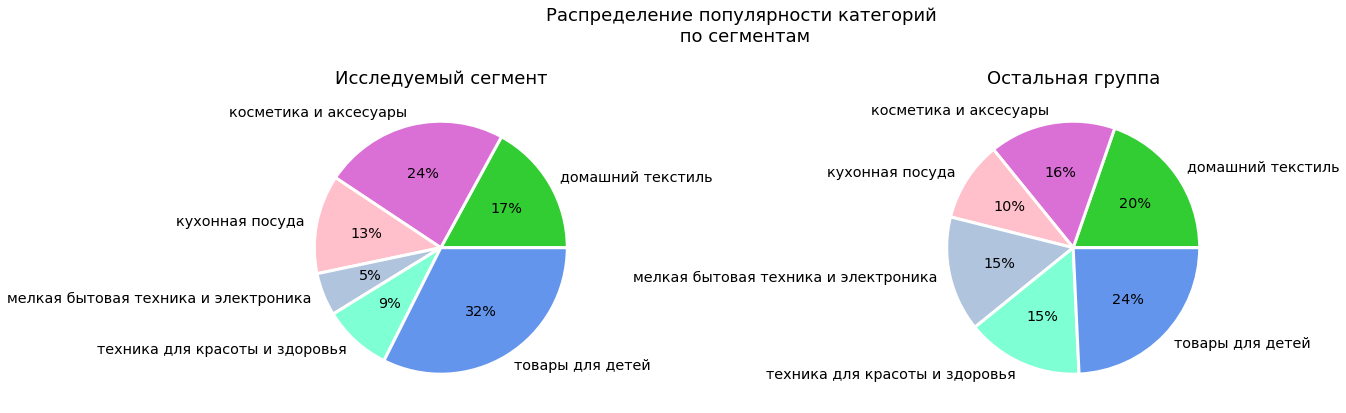

In [91]:
fig, ax = plt.subplots(1,2, figsize=(17,7))
fig.suptitle(f'Распределение популярности категорий\n по сегментам\n')

# датафрейм с сегментом
df = df_segments.query('сегмент == "исследуемый"')\
    .pivot_table(index='популярная_категория', values='длительность', aggfunc='count')
df = df.reset_index()
df.columns=['популярная_категория', 'кол-во']

# датафрейм с остальной группой
df1 = df_segments.query('сегмент == "остальные"')\
    .pivot_table(index='популярная_категория', values='длительность', aggfunc='count')
df1 = df1.reset_index()
df1.columns=['популярная_категория', 'кол-во']

# названия категорий
labels_c = df['популярная_категория']
# цвет категории
colours = {'товары для детей':'cornflowerblue',
           'домашний текстиль':'LimeGreen',
           'косметика и аксесуары':'orchid',
           'кухонная посуда':'pink',
           'техника для красоты и здоровья':'aquamarine',
           'мелкая бытовая техника и электроника':'lightsteelblue'}

# пирог для целевого сегмента
df.plot(kind='pie',
        y="кол-во",
        autopct='%1.0f%%',
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        textprops={'size': 'x-large'}, 
        labels= labels_c,
        colors=[colours[key] for key in labels_c],
        legend=False, 
        title = ("Исследуемый сегмент"), 
        ax = ax[0]).set(ylabel='')

# пирог для остальной группы
df1.plot(kind='pie',
         y="кол-во",
         autopct='%1.0f%%',
         wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
         textprops={'size': 'x-large'}, 
         labels= labels_c,
         colors=[colours[key] for key in labels_c],
         legend=False, 
         title = ("Остальная группа"), 
         ax = ax[1]).set(ylabel='')

plt.subplots_adjust(wspace=1)        

Анализ графиков распределения популярности категорий говорит о том, что:
1. Среди обеих групп наиболее популярной категорией является категория `товары для детей`. Но при этом в исследуемом сегменте на эту категорию приходится большая доля 32% против 24%.
2. На втором месте по популярности в сегменте категория `косметика и аксесуары` 24% против 16% в остальной группе.
3. На третьем месте категория `домашний текстиль` 17% против 20% в остально группе клиентов.
4. Общая доля категорий `кухонная посуда`, `техника для красоты и здоровья`, `мелкая бытовая техника и электроника` сотавила 27% для целевой категории против 40% для остальной группы.

Таким образом, стоит предложить клиентам сегмента больше маркетинговых коммуникаций для следующих трех наиболее популярных категорий товаров сегмента: `товары для детей`, `косметика и аксесуары`, `домашний текстиль`.

---
---

### Выводы
В качестве сегмента анализа была выбрана группа клиентов с высоким риском снижения пользовательской активности (>= 0.9) и высокой прибыльностью для компании (>= 4, где 4 — середина распределения прибыльности клиентов).

На основе анализа данных сегмента в сравнении с остальной группой клиентов сделаны следующие выводы:
1. За текущий месяц сегментские клиенты получали столько же маркетинговых предложений, при этом за полгода на клиентов сегмента в среднем приходится меньше маркетинговых коммуникаций.

2. Клиенты сегмента:
    * просматривают меньше страниц за визит,
    * неоплаченных товаров в корзине за три месяца больше,
    * чаще покупают товары по акции.
    
Из чего следует вывод, что клиенты быстро выбирают нужные товары и ждут удобных акций для приобретения товаров.
 
3. Самой популярной категорией сегмента является категория `товары для детей` — 32%. Следом идет категория `косметика и аксесуары` — 24%. На третьем месте по популяности — домашний текстиль 17%.

На основе выводов для сохранения пользовательской активности наиболее прибыльной группы в зоне риска снижения активности предлагается следующее решение:
    
***Предложить клиентам сегмента больше маркетинговых коммуникаций для следующих трех наиболее популярных категорий товаров сегмента: `товары для детей`, `косметика и аксесуары`, `домашний текстиль`.***

---
---
---

<a id='section_9'></a>
## Итоговые выводы

Интернет-магазин «В один клик» продаёт разные товары. Активность покупателей начала снижаться. Привлекать новых клиентов не так эффективно.

Возможный выход — удерживать активность постоянных клиентов с помощью персонализированных предложений.

1. В доступе было 4 датафрейма:

`df_market_file` — таблица с данными о поведении покупателей на сайте, о его продуктовом поведении и коммуникациях компании с клиентом;

`df_market_money` — таблица с данными о выручке сайта от клиента по периодам;

`df_morket_time` — таблица с данными о проведенном клиентом на сайте времени по периода;

`df_money` — таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца.


На этапе предобработки данных были устранены неявные дубликаты в `df_market_file`.

На этапе исследовательского анализа данных были устранены выбивающиеся значения в таблице `df_market_money`. Были отобраны только те клиенты, у которых пользовательская активность не менее трех месяцев.

На этапе корреляционного анализа не было выявлено мультиколлинеарности среди входных признаков.

2. Для поиска лучшей модели данные были разделены на тренировочную и тестовую выборку, целевой признак был закодирован с помощью `LabelEncoder()`. 

Были подготовлены пайплайны для кодирования категориальных данных и скалирования числовых данных для линейных и нелинейных моделей отдельно.

Было собрано два итоговых пайплайна, содержащих в себе этап подготовки данных и обучения модели: для линейных моделей и для нелинейных моделей.

Для поиска лучшей модели среди пяти: `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()`, `SVC(kernel='rbf'|'linear')`; был использован метод GridSearchCV(), которому в качестве сетки был передан список словарей. Элемент списка отечал за модель, а словари задавали гиперпараметры для каждой модели. В качестве метрики был выбран ROC AUC score, так как он подходит для сравнения разных моделей межжду собой.

3. В ходе поиска была получена лучшая модель со следующими гиперпараметрами `SVC(C=0.5, kernel='rbf', gamma='scale', probability=True, random_state=42)`.

Среди всех поданных модели признаков можно выделить следующие наиболее важные признаки:
* кол-во страниц за визит;
* кол-во минут на сайте в предыдущем месяце;
* кол-во минут на сайте в текущем месяце;
* ср.месячная доля покупок по акции;
* ср. просмотр категорий за визит в течение месяца;
* кол-во неоплаченных продуктов за квартал;
* выручка за препредыдущий месяц;
* ср.месячное значение маркетинговых коммуникаций за полгода;
* выручка за предыдущий месяц.

4. В качестве сегмента анализа была выбрана группа клиентов с высоким риском снижения пользовательской активности (>= 0.9) и высокой прибыльностью для компании (>= 4, где 4 — середина распределения прибыльности клиентов).

В ходе анализа был сделан вывод, клиенты быстро выбирают нужные товары и ждут удобных акций для приобретения товаров. Для сохранения пользовательской активности предлагается:

*Предложить клиентам сегмента больше маркетинговых коммуникаций для следующих трех наиболее популярных категорий товаров сегмента: `товары для детей`, `косметика и аксесуары`, `домашний текстиль`.*